In [23]:
start_index = 1
from rac.experiment_data import ExperimentReader
exp_reader = ExperimentReader(["rand"])
config = {
    "general_options": {
        "experiment_name": "info_gain_exp",
        "num_repeats": 14,
        "n_workers": 14,
        "local": True,
        "verbose": False
    },
    "experiment_options": {
        "seed": 33,
        "num_feedback": 0.001,
        "noise_level": [0.0, 0.4],
        "persistent_noise_level": 0.0,
        "force_global_update": True,
        "save_matrix_data": False,
        "infer_sims": [False],
        "predict_sims": False,
        "clustering_alg": "mean_field",
        "mean_field_beta": [5],
        "info_gain_beta": [0.1, 1, 5, 20],
        "info_gain_lambda": [-1, 1, 5, 20],
        "recompute_pe": [True, False],
        "running_avg": [False, True],
        "iterate_mf": [False, True]
    },
    "sim_init_options": {
        "K_init": 10,
        "sim_init": 0.1,
        "sim_init_type": ["zeros"]
    },
    "query_strategy_options": {
        "acq_fn": ["info_gain"],
        "eps": 0.3,
        "beta": 1,
        "tau": 7,
        "alpha": 1
    },
    "dataset_options": {
        "dataset": "synthetic",
        "n_samples": 250,
        "n_clusters": 10,
        "class_balance": None
    }
}


start_index = exp_reader.generate_experiments(
    folder="../configs/info_gain_exp/", 
    options_to_keep=[],
    start_index=start_index,
    **config
)

In [24]:
from rac.experiment_data import ExperimentReader
exp_reader = ExperimentReader(["rand"])
config = {
    "general_options": {
        "experiment_name": "info_gain_exp",
        "num_repeats": 14,
        "n_workers": 14,
        "local": True,
        "verbose": False
    },
    "experiment_options": {
        "seed": 33,
        "num_feedback": 0.001,
        "noise_level": [0.0, 0.4],
        "persistent_noise_level": 0.0,
        "force_global_update": True,
        "save_matrix_data": False,
        "infer_sims": [False],
        "predict_sims": False,
        "clustering_alg": "mean_field",
        "mean_field_beta": [5],
        "info_gain_beta": [0.1, 1, 5, 20],
        "info_gain_lambda": [-1, 1, 5, 20],
        "recompute_pe": [True, False],
        "running_avg": [False, True],
        "iterate_mf": [False, True]
    },
    "sim_init_options": {
        "K_init": 10,
        "sim_init": 0.1,
        "sim_init_type": ["zeros"]
    },
    "query_strategy_options": {
        "acq_fn": ["freq"],
        "eps": 0.3,
        "beta": 1,
        "tau": 7,
        "alpha": 1
    },
    "dataset_options": {
        "dataset": "synthetic",
        "n_samples": 250,
        "n_clusters": 10,
        "class_balance": None
    }
}


start_index = exp_reader.generate_experiments(
    folder="../configs/info_gain_exp/", 
    options_to_keep=[],
    start_index=start_index,
    **config
)

c:\github_projects\robust-active-clustering\rac\experiment_data.py:529: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
c:\github_projects\robust-active-clustering\rac\experiment_data.py:529: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
c:\github_projects\robust-active-clustering\rac\experiment_data.py:529: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
c:\github_projects\robust-active-clustering\rac\experiment_data.py:529: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
c:\github_projects\robust-active-clustering\rac\experiment_data.py:529: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
c:\github_projects\robust-active-clustering\rac\experiment_data.py:529: UserWarning: FixedFormatter should only be used 

KeyboardInterrupt: 

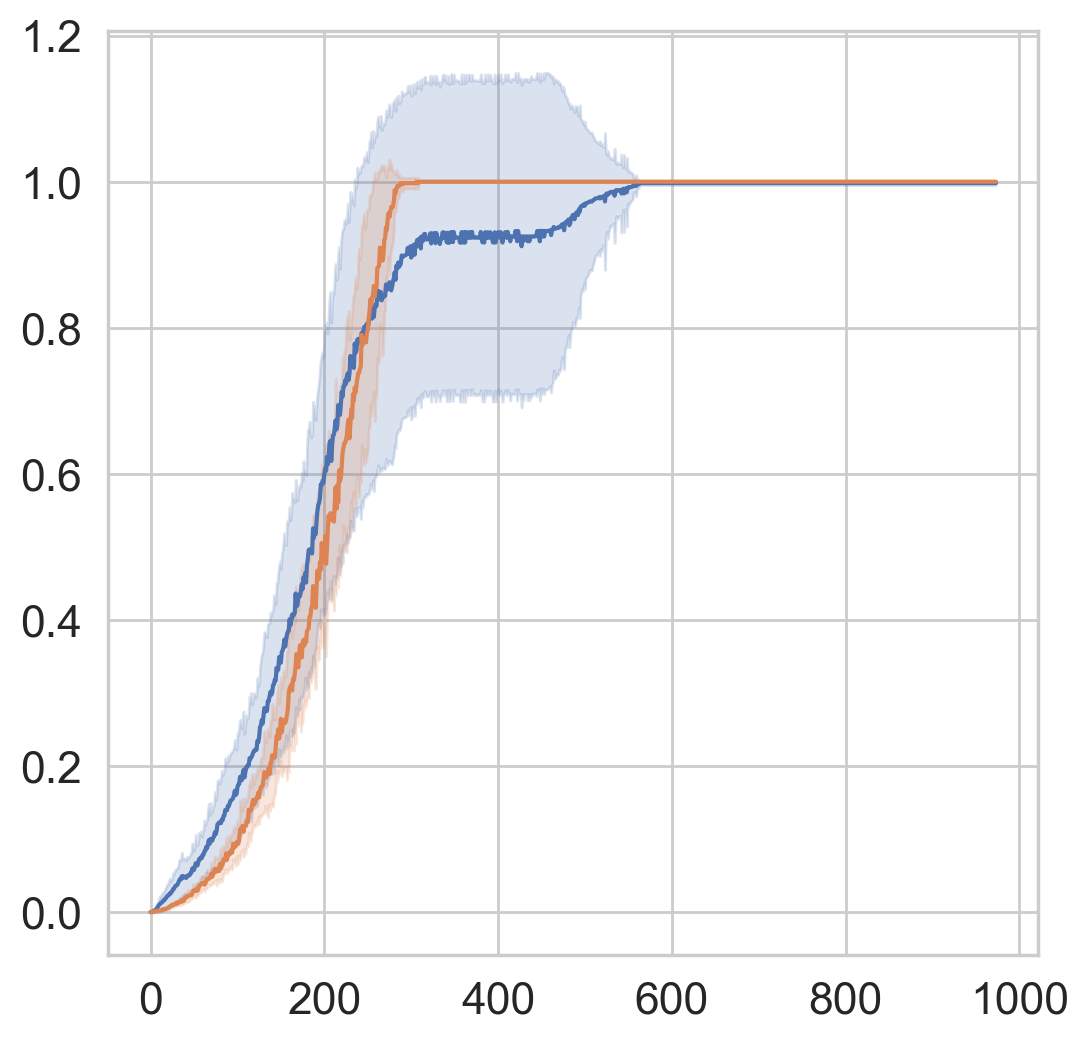

In [288]:
from rac.experiment_data import ExperimentReader
metrics = ["rand", "ami"]
ac = ExperimentReader(metrics=metrics)
config = {
    "general_options": {
        "experiment_name": "info_gain_exp",
        "num_repeats": 14,
        "n_workers": 14,
        "local": True,
        "verbose": False
    },
    "experiment_options": {
        "seed": 33,
        "num_feedback": 0.001,
        "noise_level": [0.0, 0.4],
        "persistent_noise_level": 0.0,
        "force_global_update": True,
        "save_matrix_data": False,
        "infer_sims": [False],
        "predict_sims": False,
        "clustering_alg": "mean_field",
        "mean_field_beta": [5],
        "info_gain_beta": [0.1, 1, 5, 20],
        "info_gain_lambda": [-1, 1, 5, 20],
        "recompute_pe": [True, False],
        "running_avg": [False, True]
    },
    "sim_init_options": {
        "K_init": 10,
        "sim_init": 0.1,
        "sim_init_type": ["zeros"]
    },
    "query_strategy_options": {
        "acq_fn": ["info_gain", "freq"],
        "eps": 0.3,
        "beta": 1,
        "tau": 7,
        "alpha": 1
    },
    "dataset_options": {
        "dataset": "synthetic",
        "n_samples": 250,
        "n_clusters": 10,
        "class_balance": None
    }
}


data = ac.read_all_data(folder="../experiment_results_local/info_gain_exp")
ac.generate_AL_curves(
    data,
    save_location="../plots/info_gain_exp2",
    categorize=["noise_level", "running_avg", "info_gain_beta"],
    compare=["acq_fn", "info_gain_lambda"],
    vary=["x"],
    auc=True,
    summary_method="auc_max_ind",
    indices=[], 
    threshold=1,
    err_style="band",
    marker="o",
    markersize=6,
    capsize=6,
    linestyle="solid",
    **config
)

In [73]:
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from itertools import combinations
import numpy as np
import time
from rac.correlation_clustering import max_correlation, max_correlation_dynamic_K, fast_max_correlation, mean_field_clustering

def generate_similarity_matrix_with_kmeans(n_samples, n_classes, X, labels, gamma):
    # Run k-means clustering
    kmeans = KMeans(n_clusters=n_classes, random_state=0).fit(X)
    C = kmeans.labels_

    # Initialize the similarity matrix with zeros
    S = np.zeros((n_samples, n_samples))
    
    # Set the pairwise similarity
    for i in range(n_samples):
        for j in range(i+1, n_samples):  # Ensure the matrix is symmetric
            if np.random.rand() < gamma:
                # With probability gamma, assign a random number in [-1, 1]
                similarity = np.random.uniform(-1, 1)
            else:
                # Otherwise, set similarity based on k-means clustering
                similarity = 1 if C[i] == C[j] else -1
            S[i, j] = S[j, i] = similarity
    
    # Make sure the diagonal is 0
    np.fill_diagonal(S, 0)
    
    return S

def compare_all_algorithms(graph, true_labels, initial_K_guess):
    results = {}
    algorithms = {
        'old_max_correlation_dynamic_K': max_correlation_dynamic_K,
        'max_correlation': max_correlation,
        'fast_max_correlation': fast_max_correlation,
        'mean_field': mean_field_clustering
    }
    
    for name, algorithm in algorithms.items():
        # Measure runtime
        start_time = time.time()
        true_k = len(np.unique(true_labels)) 
        if 'dynamic' in name:  # Dynamic K versions require an initial K guess
            predicted_labels, _ = algorithm(graph, initial_K_guess, 10)
        elif "mean_field" in name:
            predicted_labels, _, _ = algorithm(S=graph, K=initial_K_guess, betas=[2], max_iter=100, tol=1e-10, noise_level=0.0)
        else:  # Fixed K versions use the true number of clusters
            predicted_labels, _ = algorithm(graph, true_k, 10)
        runtime = time.time() - start_time
        
        # Calculate ARI
        ari = adjusted_rand_score(true_labels, predicted_labels)
        
        # Store results
        results[name] = {'ari': ari, 'runtime': runtime, 'predicted_labels': predicted_labels}
    
    ari_between_results = {}
    # Calculate ARI between the solutions of the algorithms
    for (name1, result1), (name2, result2) in combinations(results.items(), 2):
        ari_between = adjusted_rand_score(result1['predicted_labels'], result2['predicted_labels'])
        ari_between_results[f'ari_between_{name1}_{name2}'] = ari_between

    # Update results with the ARI between algorithms
    results.update(ari_between_results)

    return results

def generate_datasets_and_compare_algorithms(n_datasets=1, gammas=[0, 0.3, 0.5, 0.7, 0.9], initial_K_guess=1):
    all_results = []
    for dataset_index in range(n_datasets):
        # Generate a dataset
        X, y = make_classification(n_samples=50, n_features=5, n_informative=5, n_redundant=0, n_clusters_per_class=1, n_classes=10)
        
        # For each gamma, generate similarity matrix and compare algorithms
        for gamma in gammas:
            S = generate_similarity_matrix_with_kmeans(n_samples=50, n_classes=10, X=X, labels=y, gamma=gamma)
            comparison_results = compare_all_algorithms(S, y, initial_K_guess)
            all_results.append({
                'dataset': dataset_index + 1,
                'gamma': gamma,
                'results': comparison_results
            })
    
    return all_results

In [74]:
results_with_kmeans = generate_datasets_and_compare_algorithms()
for result in results_with_kmeans:
    print(result)

Converged after 7 iterations
Converged after 29 iterations
{'dataset': 1, 'gamma': 0, 'results': {'old_max_correlation_dynamic_K': {'ari': 0.19530791788856305, 'runtime': 0.1707308292388916, 'predicted_labels': array([6, 7, 2, 2, 3, 4, 6, 3, 2, 1, 6, 3, 2, 4, 2, 2, 6, 2, 7, 3, 0, 1,
       4, 1, 2, 1, 8, 0, 3, 9, 8, 1, 4, 3, 5, 6, 4, 8, 0, 5, 0, 3, 7, 4,
       0, 2, 5, 2, 1, 6])}, 'max_correlation': {'ari': 0.19530791788856305, 'runtime': 0.04597282409667969, 'predicted_labels': array([9, 3, 0, 0, 5, 1, 9, 5, 0, 6, 9, 5, 0, 1, 0, 0, 9, 0, 3, 5, 7, 6,
       1, 6, 0, 6, 2, 7, 5, 4, 2, 6, 1, 5, 8, 9, 1, 2, 7, 8, 7, 5, 3, 1,
       7, 0, 8, 0, 6, 9])}, 'fast_max_correlation': {'ari': 0.19530791788856305, 'runtime': 0.08298492431640625, 'predicted_labels': array([3, 9, 1, 1, 2, 6, 3, 2, 1, 0, 3, 2, 1, 6, 1, 1, 3, 1, 9, 2, 8, 0,
       6, 0, 1, 0, 7, 8, 2, 5, 7, 0, 6, 2, 4, 3, 6, 7, 8, 4, 8, 2, 9, 6,
       8, 1, 4, 1, 0, 3])}, 'mean_field': {'ari': 0.19530791788856305, 'runtime': 0.166449

In [1]:
import numpy as np
from itertools import combinations, product
from scipy.special import logsumexp

def generate_clusterings(n):
    if n == 0:
        yield []
        return
    for clustering in generate_clusterings(n - 1):
        for i, subset in enumerate(clustering):
            yield clustering[:i] + [subset + [n - 1]] + clustering[i + 1:]
        yield clustering + [[n - 1]]

def compute_cost(clustering, similarity_matrix):
    cost = 0
    for cluster in clustering:
        if len(cluster) > 1:
            for i, j in combinations(cluster, 2):
                cost -= similarity_matrix[i][j]
    return cost

def compute_gibbs_distribution(clusterings, similarity_matrix, beta=1.0):
    costs = np.array([compute_cost(clustering, similarity_matrix) for clustering in clusterings])
    normalization_constant = logsumexp(-beta * costs)
    probabilities = np.exp(-beta * costs - normalization_constant)
    return probabilities

def compute_entropy(probabilities):
    return -np.sum(probabilities * np.log(probabilities + 1e-10))

def update_similarity_matrix(similarity_matrix, pair, value):
    updated_matrix = similarity_matrix.copy()
    i, j = pair
    updated_matrix[i][j] = updated_matrix[j][i] = value
    return updated_matrix

def probability_e_given_C(e, clustering):
    i, j = e
    in_same_cluster = any(i in cluster and j in cluster for cluster in clustering)
    return (in_same_cluster, not in_same_cluster)  # (P(e=+1|C), P(e=-1|C))

def compute_conditional_probabilities_e(similarity_matrix, e, clusterings, beta=1.0):
    gibbs_probs = compute_gibbs_distribution(clusterings, similarity_matrix, beta)
    prob_e_plus = prob_e_minus = 0.0
    for clustering, prob_C in zip(clusterings, gibbs_probs):
        prob_plus, prob_minus = probability_e_given_C(e, clustering)
        prob_e_plus += prob_C * prob_plus
        prob_e_minus += prob_C * prob_minus
    return prob_e_plus, prob_e_minus

def compute_information_gain(similarity_matrix, pair, clusterings, beta=1.0):
    prob_e_plus, prob_e_minus = compute_conditional_probabilities_e(similarity_matrix, pair, clusterings, beta)

    # Compute conditional entropies with updated probabilities
    updated_matrix_similar = update_similarity_matrix(similarity_matrix, pair, 1)
    similar_probs = compute_gibbs_distribution(clusterings, updated_matrix_similar, beta)
    similar_entropy = compute_entropy(similar_probs)

    updated_matrix_dissimilar = update_similarity_matrix(similarity_matrix, pair, -1)
    dissimilar_probs = compute_gibbs_distribution(clusterings, updated_matrix_dissimilar, beta)
    dissimilar_entropy = compute_entropy(dissimilar_probs)

    # Weighted conditional entropy
    conditional_entropy = prob_e_plus * similar_entropy + prob_e_minus * dissimilar_entropy

    # Compute the initial entropy
    initial_probs = compute_gibbs_distribution(clusterings, similarity_matrix, beta)
    initial_entropy = compute_entropy(initial_probs)

    # Information gain
    return initial_entropy - conditional_entropy

# Example usage
N = 3  # Number of objects
similarity_matrix = np.zeros((N, N))  # Initial similarity matrix
clusterings = list(generate_clusterings(N))

# Initialize the information gain matrix and P(e) matrix
info_gain_matrix = np.zeros((N, N))
prob_e_matrix = np.zeros((N, N))

# Compute information gain and P(e) for each pair
for i in range(N):
    for j in range(i + 1, N):
        info_gain = compute_information_gain(similarity_matrix, (i, j), clusterings)
        prob_e_plus, prob_e_minus = compute_conditional_probabilities_e(similarity_matrix, (i, j), clusterings)
        info_gain_matrix[i][j] = info_gain_matrix[j][i] = info_gain
        prob_e_matrix[i][j] = prob_e_matrix[j][i] = prob_e_plus

# Print the information gain matrix and P(e) matrix
print("Information Gain Matrix:")
print(info_gain_matrix)
print("\nP(e) Matrix:")
print(prob_e_matrix)
print("sim matrix")
print(similarity_matrix)

Information Gain Matrix:
[[0.        0.1052291 0.1052291]
 [0.1052291 0.        0.1052291]
 [0.1052291 0.1052291 0.       ]]

P(e) Matrix:
[[0.  0.4 0.4]
 [0.4 0.  0.4]
 [0.4 0.4 0. ]]
sim matrix
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [285]:
import numpy as np
from itertools import combinations, product
from scipy.special import logsumexp

def generate_clusterings(n):
    if n == 0:
        yield []
        return
    for clustering in generate_clusterings(n - 1):
        for i, subset in enumerate(clustering):
            yield clustering[:i] + [subset + [n - 1]] + clustering[i + 1:]
        yield clustering + [[n - 1]]

def compute_cost2(clustering, similarity_matrix):
    cost = 0
    for cluster in clustering:
        if len(cluster) > 1:
            for i, j in combinations(cluster, 2):
                cost -= similarity_matrix[i][j]
    return cost

def compute_cost(clustering, similarity_matrix):
    cost = 0
    n = len(similarity_matrix)
    for i in range(n):
        for j in range(i + 1, n):
            in_same_cluster = any(i in cluster and j in cluster for cluster in clustering)
            if similarity_matrix[i][j] >= 0 and not in_same_cluster:
                cost += np.abs(similarity_matrix[i][j])
            elif similarity_matrix[i][j] < 0 and in_same_cluster:
                cost += np.abs(similarity_matrix[i][j])
    return cost

def compute_gibbs_distribution(clusterings, similarity_matrix, beta=1.0):
    costs = np.array([compute_cost(clustering, similarity_matrix) for clustering in clusterings])
    #print([clustering for clustering in clusterings])
    #print(similarity_matrix[0,1], similarity_matrix[0,2], similarity_matrix[1,2])
    #print(costs)
    normalization_constant = logsumexp(-beta * costs)
    probabilities = np.exp(-beta * costs - normalization_constant)
    #print(probabilities)
    return probabilities

def compute_gibbs_distribution2(clusterings, similarity_matrix, beta=1.0):
    costs = np.array([compute_cost(clustering, similarity_matrix) for clustering in clusterings])
    exp_values = np.exp(-beta * costs)
    normalization_constant = np.sum(exp_values)
    probabilities = exp_values / normalization_constant
    return probabilities

def compute_entropy(probabilities):
    return -np.sum(probabilities * np.log(probabilities + 1e-10))

def update_similarity_matrix(similarity_matrix, pair, value):
    updated_matrix = similarity_matrix.copy()
    i, j = pair
    updated_matrix[i][j] = updated_matrix[j][i] = value
    return updated_matrix

def probability_e_given_C(e, clustering):
    i, j = e
    in_same_cluster = any(i in cluster and j in cluster for cluster in clustering)
    return (in_same_cluster, not in_same_cluster)  # (P(e=+1|C), P(e=-1|C))

def compute_conditional_probabilities_e(similarity_matrix, e, clusterings, beta=1.0):
    gibbs_probs = compute_gibbs_distribution(clusterings, similarity_matrix, beta)
    prob_e_plus = prob_e_minus = 0.0
    for clustering, prob_C in zip(clusterings, gibbs_probs):
        prob_plus, prob_minus = probability_e_given_C(e, clustering)
        prob_e_plus += prob_C * prob_plus
        prob_e_minus += prob_C * prob_minus
    return prob_e_plus, prob_e_minus


def compute_entropy_with_constraint(clusterings, similarity_matrix, constraint_pair, in_same_cluster_constraint):
    # Filter clusterings based on the constraint
    filtered_clusterings = [
        clustering for clustering in clusterings 
        if any(constraint_pair[0] in cluster and constraint_pair[1] in cluster for cluster in clustering) == in_same_cluster_constraint
    ]

    # Compute Gibbs distribution for the filtered clusterings
    gibbs_probs = compute_gibbs_distribution(filtered_clusterings, similarity_matrix)
    return compute_entropy(gibbs_probs)

def compute_information_gain(similarity_matrix, pair, clusterings, beta=1.0):
    prob_e_plus, prob_e_minus = compute_conditional_probabilities_e(similarity_matrix, pair, clusterings, beta)

    # Compute conditional entropies with updated probabilities
    updated_matrix_similar = update_similarity_matrix(similarity_matrix, pair, 1)
    similar_probs = compute_gibbs_distribution(clusterings, updated_matrix_similar, beta)
    similar_entropy = compute_entropy(similar_probs)
    #similar_entropy = compute_entropy_with_constraint(clusterings, similarity_matrix, (0, 1), True)

    updated_matrix_dissimilar = update_similarity_matrix(similarity_matrix, pair, -1)
    dissimilar_probs = compute_gibbs_distribution(clusterings, updated_matrix_dissimilar, beta)
    dissimilar_entropy = compute_entropy(dissimilar_probs)
    #dissimilar_entropy = compute_entropy_with_constraint(clusterings, similarity_matrix, (0, 1), False)

    prob_e_plus= (similarity_matrix[pair[0], pair[1]] + 1) / 2
    prob_e_minus = 1-prob_e_plus
    # Weighted conditional entropy
    conditional_entropy = prob_e_plus * similar_entropy + prob_e_minus * dissimilar_entropy

    # Compute the initial entropy
    initial_probs = compute_gibbs_distribution(clusterings, similarity_matrix, beta)
    initial_entropy = compute_entropy(initial_probs)

    # Information gain
    return initial_entropy - conditional_entropy

# Extended range of similarity values
extended_similarity_values = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]

# Generate all possible clusterings for 3 objects
clusterings = list(generate_clusterings(3))

# Compute information gain for (a, b) in all configurations
ab_extended_info_gain_corrected = []

for s_ab, s_ac, s_bc in product(extended_similarity_values, repeat=3):
    similarity_matrix = np.array([[0, s_ab, s_ac], [s_ab, 0, s_bc], [s_ac, s_bc, 0]])

    info_gain_ab = compute_information_gain(similarity_matrix, (0, 1), clusterings, beta=10)
    ab_extended_info_gain_corrected.append(((s_ab, s_ac, s_bc), info_gain_ab))

# Sort the results by I(a, b) in descending order
sorted_ab_extended_info_gain_corrected = sorted(ab_extended_info_gain_corrected, key=lambda x: x[1], reverse=True)

# Display the top 10 configurations
for config, gain in sorted_ab_extended_info_gain_corrected[:]:
    print(f"Configuration: {config}, Information Gain for (a, b): {gain}")

Configuration: (0, -1, 0), Information Gain for (a, b): 0.7513728988686713
Configuration: (0, 0, -1), Information Gain for (a, b): 0.7513728988686713
Configuration: (0, -0.75, 0), Information Gain for (a, b): 0.7510233427622747
Configuration: (0, 0, -0.75), Information Gain for (a, b): 0.7510233427622747
Configuration: (0, -0.5, 0), Information Gain for (a, b): 0.7480919920802865
Configuration: (0, 0, -0.5), Information Gain for (a, b): 0.7480919920802865
Configuration: (0, -0.25, 0), Information Gain for (a, b): 0.7307606353285476
Configuration: (0, 0, -0.25), Information Gain for (a, b): 0.7307606353285476
Configuration: (0.25, -1, 0.25), Information Gain for (a, b): 0.7272689686663061
Configuration: (0.25, 0.25, -1), Information Gain for (a, b): 0.7272689686663061
Configuration: (0.25, -0.75, 0.25), Information Gain for (a, b): 0.7219939580293776
Configuration: (0.25, 0.25, -0.75), Information Gain for (a, b): 0.7219939580293775
Configuration: (0, 0, 0), Information Gain for (a, b):

In [272]:
s_ab = 0.9
s_ac = 1
s_bc = 1
similarity_matrix_111 = np.array([[0, s_ab, s_ac], [s_ab, 0, s_bc], [s_ac, s_bc, 0]])

beta = 1
# Step 1: Compute the initial entropy H(C)
initial_probs_111 = compute_gibbs_distribution(clusterings, similarity_matrix_111, beta=beta)
initial_entropy_111 = compute_entropy(initial_probs_111)

# Step 2: Compute the conditional entropies H(C | e=+1) and H(C | e=-1)
# For S(a, b) = +1
updated_matrix_similar_111 = update_similarity_matrix(similarity_matrix_111, (0, 1), 1)
similar_probs_111 = compute_gibbs_distribution(clusterings, updated_matrix_similar_111, beta=beta)
similar_entropy_111 = compute_entropy(similar_probs_111)

# For S(a, b) = -1
updated_matrix_dissimilar_111 = update_similarity_matrix(similarity_matrix_111, (0, 1), -1)
dissimilar_probs_111 = compute_gibbs_distribution(clusterings, updated_matrix_dissimilar_111, beta=beta)
dissimilar_entropy_111 = compute_entropy(dissimilar_probs_111)

# Step 3: Compute P(e)
prob_e_plus_111, prob_e_minus_111 = compute_conditional_probabilities_e(similarity_matrix_111, (0, 1), clusterings, beta=beta)
prob_e_plus_111 = (s_ab + 1) / 2
prob_e_minus_111 = 1 - prob_e_plus_111

# Step 4: Weighted Conditional Entropy
weighted_conditional_entropy_111 = prob_e_plus_111 * similar_entropy_111 + prob_e_minus_111 * dissimilar_entropy_111

# Step 5: Information Gain
info_gain_ab_111 = initial_entropy_111 - weighted_conditional_entropy_111

initial_entropy_111, similar_entropy_111, dissimilar_entropy_111, prob_e_plus_111, prob_e_minus_111, weighted_conditional_entropy_111, info_gain_ab_111



[[[0, 1, 2]], [[0, 1], [2]], [[0, 2], [1]], [[0], [1, 2]], [[0], [1], [2]]]
0.9 1.0 1.0
[0.  2.  1.9 1.9 2.9]
[0.67136815 0.0908598  0.10041561 0.10041561 0.03694084]
[[[0, 1, 2]], [[0, 1], [2]], [[0, 2], [1]], [[0], [1, 2]], [[0], [1], [2]]]
1.0 1.0 1.0
[0. 2. 2. 2. 3.]
[0.68691088 0.09296328 0.09296328 0.09296328 0.03419928]
[[[0, 1, 2]], [[0, 1], [2]], [[0, 2], [1]], [[0], [1, 2]], [[0], [1], [2]]]
-1.0 1.0 1.0
[1. 3. 1. 1. 2.]
[0.2854521  0.03863174 0.2854521  0.2854521  0.10501196]
[[[0, 1, 2]], [[0, 1], [2]], [[0, 2], [1]], [[0], [1, 2]], [[0], [1], [2]]]
0.9 1.0 1.0
[0.  2.  1.9 1.9 2.9]
[0.67136815 0.0908598  0.10041561 0.10041561 0.03694084]


(1.0688649668370704,
 1.0359282240806909,
 1.4359564797946758,
 0.95,
 0.050000000000000044,
 1.0559296368663902,
 0.012935329970680254)